# Weak Supervision methods experimentation and selection for ADEGuard

In [148]:
# loading libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import ray
from tqdm import tqdm
import multiprocessing
import multiprocessing



In [118]:
# loading the annotated GOLD dataset
vaers_gold_annotated = pd.read_csv('/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/gold_annotated_data/vaers_gold_annotated_cleaned.csv')

In [119]:
# Convert columns to lowercase
vaers_gold_annotated["symptom_text"] = vaers_gold_annotated["symptom_text"].str.lower()
vaers_gold_annotated["entity_value"] = vaers_gold_annotated["entity_value"].str.lower()


In [120]:
# Checking if lower() worked
vaers_gold_annotated.head(11)

,vaers_id,symptom_text,start,end,label,entity_value,year,span_length
0,908091,"fever, chills, nausea, sore throat, headache, ...",0,5,ADE,fever,2020,1
1,908091,"fever, chills, nausea, sore throat, headache, ...",7,13,ADE,chills,2020,1
2,908091,"fever, chills, nausea, sore throat, headache, ...",15,21,ADE,nausea,2020,1
3,908091,"fever, chills, nausea, sore throat, headache, ...",23,34,ADE,sore throat,2020,2
4,908091,"fever, chills, nausea, sore throat, headache, ...",36,44,ADE,headache,2020,1
5,908091,"fever, chills, nausea, sore throat, headache, ...",46,64,ADE,extreme body aches,2020,3
6,908091,"fever, chills, nausea, sore throat, headache, ...",69,74,ADE,cough,2020,1
7,908091,"fever, chills, nausea, sore throat, headache, ...",76,81,ADE,fever,2020,1
8,908091,"fever, chills, nausea, sore throat, headache, ...",126,141,ADE,rapid heartbeat,2020,2
9,908091,"fever, chills, nausea, sore throat, headache, ...",183,203,ADE,difficulty breathing,2020,2


In [121]:
len(vaers_gold_annotated)

4782

In [122]:
vaers_gold_annotated[
    (vaers_gold_annotated['label'] == 'ADE') &
    (vaers_gold_annotated['entity_value'].str.lower() == 'mrna-1273')
]

,vaers_id,symptom_text,start,end,label,entity_value,year,span_length


## Exploring methods for WeakSupervisions

### 1. Dictionary LF for DRUGS

#### Applying to all GOLD records to compare the Label finctions performance.

In [123]:
# -----------------------------
# DRUG dictionary from GOLD annotations
# -----------------------------

# Keep only the first occurrence of each vaers_id
vaers_gold_annotated_unique = vaers_gold_annotated.drop_duplicates(subset=["vaers_id"], keep="first")

# Filtering only for DRUG and reset index
vaers_gold_annotated_DRUG = vaers_gold_annotated[vaers_gold_annotated["label"] == "DRUG"]
vaers_gold_annotated_DRUG = vaers_gold_annotated_DRUG.reset_index(drop=True)

dict_DRUG = vaers_gold_annotated_DRUG["entity_value"].unique().tolist()

# -----------------------------
# ADE dictionary from GOLD annotations
# -----------------------------

vaers_gold_annotated_ADE = vaers_gold_annotated[vaers_gold_annotated["label"] == "ADE"]
vaers_gold_annotated_ADE = vaers_gold_annotated_ADE.reset_index(drop=True)

dict_ADE = vaers_gold_annotated_ADE["entity_value"].unique().tolist()

In [124]:
len(dict_DRUG)

239

In [125]:
len(dict_ADE)

1360

In [41]:
# -----------------------------
# General LF function (works for DRUG & ADE)
# -----------------------------
def lf_dict(text, keyword_dict, label_name):
    """
    Apply regex dictionary matching and return matches with label_name.
    """
    text = text.decode("utf-8") if isinstance(text, bytes) else text
    matches = []
    for keyword in keyword_dict:
        for m in re.finditer(rf"\b{re.escape(keyword)}\b", text, flags=re.I):
            entity_value = text[m.start():m.end()]
            matches.append({
                "start": m.start(),
                "end": m.end(),
                "label": label_name,      # <-- dynamic label
                "entity_value": entity_value
            })
    return matches


In [127]:
# -----------------------------
# Apply regex functions to DataFrame
# -----------------------------
# Assume df_gold is your current gold annotation DataFrame
# We want one row per match in regex predictions

all_predictions = []

for idx, row in vaers_gold_annotated[['vaers_id', 'symptom_text']].drop_duplicates().iterrows():
    vaers_id = row['vaers_id']
    text = row['symptom_text']

    # Apply DRUG LF
    drug_matches = lf_dict(text, dict_DRUG, "DRUG")
    for match in drug_matches:
        match['vaers_id'] = vaers_id
        all_predictions.append(match)

    # Apply ADE LF
    ade_matches = lf_dict(text, dict_ADE, "ADE")
    for match in ade_matches:
        match['vaers_id'] = vaers_id
        all_predictions.append(match)

# Convert to DataFrame
df_pred = pd.DataFrame(all_predictions)
df_pred = df_pred[['vaers_id', 'start', 'end', 'label', 'entity_value']]


In [128]:
df_pred.sort_values(by='vaers_id').head(10)

,vaers_id,start,end,label,entity_value
0,908091,0,5,ADE,fever
1,908091,76,81,ADE,fever
2,908091,36,44,ADE,headache
3,908091,7,13,ADE,chills
4,908091,54,64,ADE,body aches
5,908091,15,21,ADE,nausea
6,908091,210,218,ADE,covid 19
7,908091,69,74,ADE,cough
10,909141,23,29,ADE,chills
11,909141,31,41,ADE,body aches


#### Bar plot for preds for DRUG using RE

In [ ]:
# -----------------------------
# Plot DRUG values
# -----------------------------
df_drug = df_pred[df_pred['label'] == 'DRUG']

# Count frequency of each entity value (case-insensitive)
value_counts_drug = df_drug['entity_value'].str.lower().value_counts()
top_50_drug = value_counts_drug.head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_50_drug.index, top_50_drug.values, color='skyblue')
plt.title('Frequency of Values for Label "DRUG"')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.gca().invert_yaxis()  # Highest at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# -----------------------------
# Plot ADE values
# -----------------------------
df_ade = df_pred[df_pred['label'] == 'ADE']

# Count frequency of each entity value (case-insensitive)
value_counts_ade = df_ade['entity_value'].str.lower().value_counts()
top_50_ade = value_counts_ade.head(50)

plt.figure(figsize=(12, 10))
plt.barh(top_50_ade.index, top_50_ade.values, color='lightcoral')
plt.title('Frequency of Values for Label "ADE"')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



#### Computing metrics for Dic LF on ADE and DRUG

In [130]:
gold_labels = []

# Group by VAERS ID
grouped = vaers_gold_annotated.groupby("vaers_id")

for chunk_id, group in grouped:
    labels = []

    # If there are no predictions for this chunk, set labels to an empty list
    if group["label"].str.contains("No Prediction").all():
        labels = []  # Empty list for chunks with no predictions
    else:
        # Otherwise, add predictions as usual
        for _, row in group.iterrows():
            labels.append(
                {
                    "label": row["label"],
                    "start": int(row["start"]),
                    "end": int(row["end"]),
                }
            )

    gold_labels.append({"vaers_id": int(vaers_id), "labels": labels})

In [131]:
pred_labels = []

# Group by VAERS ID
grouped = df_pred.groupby("vaers_id")

for chunk_id, group in grouped:
    labels = []

    # If there are no predictions for this chunk, set labels to an empty list
    if group["label"].str.contains("No Prediction").all():
        labels = []  # Empty list for chunks with no predictions
    else:
        # Otherwise, add predictions as usual
        for _, row in group.iterrows():
            labels.append(
                {
                    "label": row["label"],
                    "start": int(row["start"]),
                    "end": int(row["end"]),
                }
            )

    pred_labels.append({"vaers_id": int(vaers_id), "labels": labels})


In [132]:
# Keep only the values of the "labels" key in pred_labels
pred_labels = [entry["labels"] for entry in pred_labels]

# Keep only the values of the "labels" key in gt_labels
gold_labels = [entry["labels"] for entry in gold_labels]

# Now pred_labels and gt_labels contain only the values of the "labels" key

In [133]:
len(pred_labels)

471

In [143]:
# ------------------------------
# NER Evaluation with NERVALUTE
# ------------------------------

from nervaluate import Evaluator
import pandas as pd

tags = ["ADE", "DRUG"]  # your entity types

# ------------------------------
# Initialize evaluator
# ------------------------------

evaluator = Evaluator(
    true=gold_labels,
    pred=pred_labels,
    tags=tags,
    loader="default",          # auto-detects your list-of-dicts format
    #min_overlap_percentage=1.0 # exact match required for partial
)

# ------------------------------
# Run evaluation
# ------------------------------

results = evaluator.evaluate()

# ------------------------------
# Overall metrics DataFrame
# ------------------------------

df_overall = pd.DataFrame([
    {
        "strategy": k,
        "precision": v.precision,
        "recall": v.recall,
        "f1": v.f1,
        "correct": v.correct,
        "incorrect": v.incorrect,
        "partial": v.partial,
        "missed": v.missed,
        "spurious": v.spurious
    }
    for k, v in results["overall"].items()
]).round(4)

print("=== Overall Metrics ===")
print(df_overall)

# ------------------------------
# Per-entity metrics DataFrame (strict strategy)
# ------------------------------

df_entities = pd.DataFrame([
    {
        "entity": entity_type,
        "precision": v["strict"].precision,
        "recall": v["strict"].recall,
        "f1": v["strict"].f1,
        "correct": v["strict"].correct,
        "incorrect": v["strict"].incorrect,
        "partial": v["strict"].partial,
        "missed": v["strict"].missed,
        "spurious": v["strict"].spurious
    }
    for entity_type, v in results["entities"].items()
]).round(4)

print("\n=== Per-Entity Metrics (strict) ===")
print(df_entities)

# ------------------------------
# Optional: summary report
# ------------------------------

print("\n=== Summary Report ===")
print(evaluator.summary_report(mode="entities", scenario="strict", digits=3))


=== Overall Metrics ===
   strategy  precision  recall      f1  correct  incorrect  partial  missed  \
0    strict     0.2578  0.3784  0.3067     1815       1438        0    1543   
1   partial     0.2640  0.3874  0.3140     1858          0     1395    1543   
2  ent_type     0.4197  0.6159  0.4992     2954        299        0    1543   
3     exact     0.2640  0.3874  0.3140     1858       1395        0    1543   

   spurious  
0      3786  
1      3786  
2      3786  
3      3786  

=== Per-Entity Metrics (strict) ===
  entity  precision  recall      f1  correct  incorrect  partial  missed  \
0    ADE     0.4573  0.3721  0.4103     1178        431        0    1557   
1   DRUG     0.1613  0.4417  0.2363      720        783        0     127   

   spurious  
0       967  
1      2960  

=== Summary Report ===
Scenario: strict

             correct   incorrect     partial      missed    spurious   precision      recall    f1-score

    ADE         1178         431           0        15

### Applying the Dict LF to 'vears_all'

In [131]:
vaers_all = pd.read_csv('/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/processed_data/vaers_all.csv')

/var/folders/cr/048sbrkd4k5f7y4yw3rstw7m0000gn/T/ipykernel_50694/567863302.py:1: DtypeWarning: Columns (7,12,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  vaers_all = pd.read_csv('/Users/joeraymond/Desktop/Data_Science_Projects/ADEGuard_AI_System/data/processed/processed_data/vaers_all.csv')


In [132]:
vaers_all = vaers_all[['VAERS_ID', 'SYMPTOM_TEXT', 'YEAR']]

In [133]:
len(vaers_all)

1112050

In [134]:
vaers_all.dropna(inplace=True)

In [135]:
vaers_all.isna().sum()

VAERS_ID        0
SYMPTOM_TEXT    0
YEAR            0
dtype: int64

In [136]:
len(vaers_all)

1110465

In [137]:
vaers_all = vaers_all.applymap(lambda s: s.lower() if type(s) == str else s)

/var/folders/cr/048sbrkd4k5f7y4yw3rstw7m0000gn/T/ipykernel_50694/3329186497.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vaers_all = vaers_all.applymap(lambda s: s.lower() if type(s) == str else s)


In [138]:
len(vaers_all)

1110465

### Applying dict LF for 2020

In [139]:
vaers_all_2020 = vaers_all[vaers_all['YEAR'] == 2020]

In [ ]:
vaers_all_2020

In [147]:

num_cpus = multiprocessing.cpu_count()
n = len(vaers_all_2020)

# Aim for ~5× number of cores in parallel tasks
num_batches = num_cpus * 5
batch_size = max(100, n // num_batches)  

print(f"Auto batch size: {batch_size}")


Auto batch size: 271


In [141]:
# Using Ray for parallel processing

# Detect number of CPU cores
num_cpus = multiprocessing.cpu_count()
print(f"Detected {num_cpus} CPU cores. Using Ray with {num_cpus} workers.")

# Start Ray with detected CPUs
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

@ray.remote
def process_batch(batch_df):
    results = []
    for _, row in batch_df.iterrows():
        vaers_id, text = row["VAERS_ID"], row["SYMPTOM_TEXT"]

        if pd.isna(text):
            continue

        text = str(text)

        # Apply DRUG LF
        for match in lf_dict(text, dict_DRUG, "DRUG"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

        # Apply ADE LF
        for match in lf_dict(text, dict_ADE, "ADE"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

    return results


# Prepare batches
df = vaers_all_2020[['VAERS_ID', 'SYMPTOM_TEXT']].drop_duplicates()
batch_size = 2000
batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

# Submit jobs
futures = [process_batch.remote(batch) for batch in batches]

# Collect results with tqdm progress bar
results = []
with tqdm(total=len(futures), desc="Processing batches") as pbar:
    while futures:
        done, futures = ray.wait(futures, num_returns=1, timeout=None)
        for obj in done:
            results.append(ray.get(obj))
            pbar.update(1)

# Flatten results
all_predictions_2020 = [m for sublist in results for m in sublist]
df_pred_2020 = pd.DataFrame(all_predictions_2020)
df_pred_2020 = df_pred_2020[['VAERS_ID', 'start', 'end', 'label', 'entity_value']]



2025-09-10 02:15:16,062	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.


Detected 8 CPU cores. Using Ray with 8 workers.


Processing batches: 100%|██████████| 6/6 [03:26<00:00, 34.39s/it] 


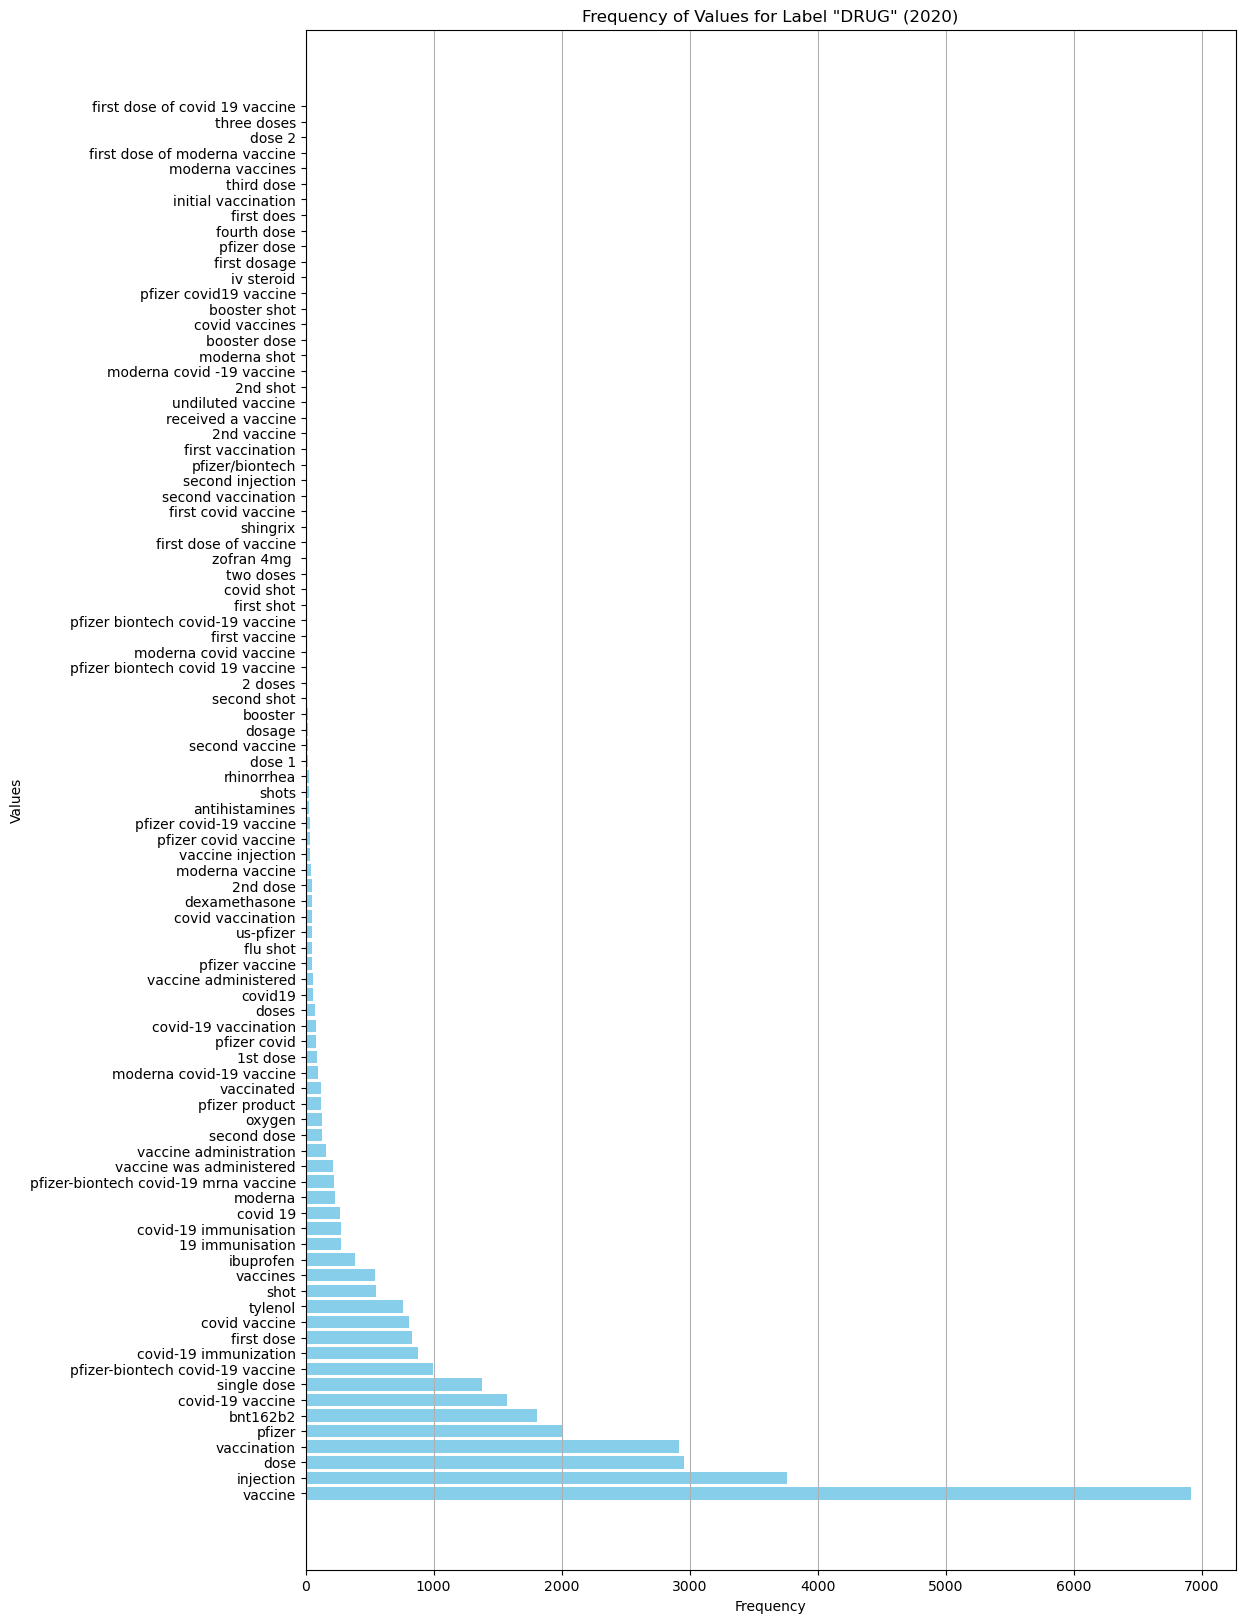

In [144]:
# Step 1: Filter the DataFrame for the label "DRUG"
entity_DRUG_2020 = df_pred_2020[df_pred_2020['label'] == 'DRUG']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_DRUG_2020 = entity_DRUG_2020['entity_value'].str.lower().value_counts()
top_10_value_counts_DRUG_2020 = value_counts_DRUG_2020.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_DRUG_2020.index, top_10_value_counts_DRUG_2020.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "DRUG" (2020)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

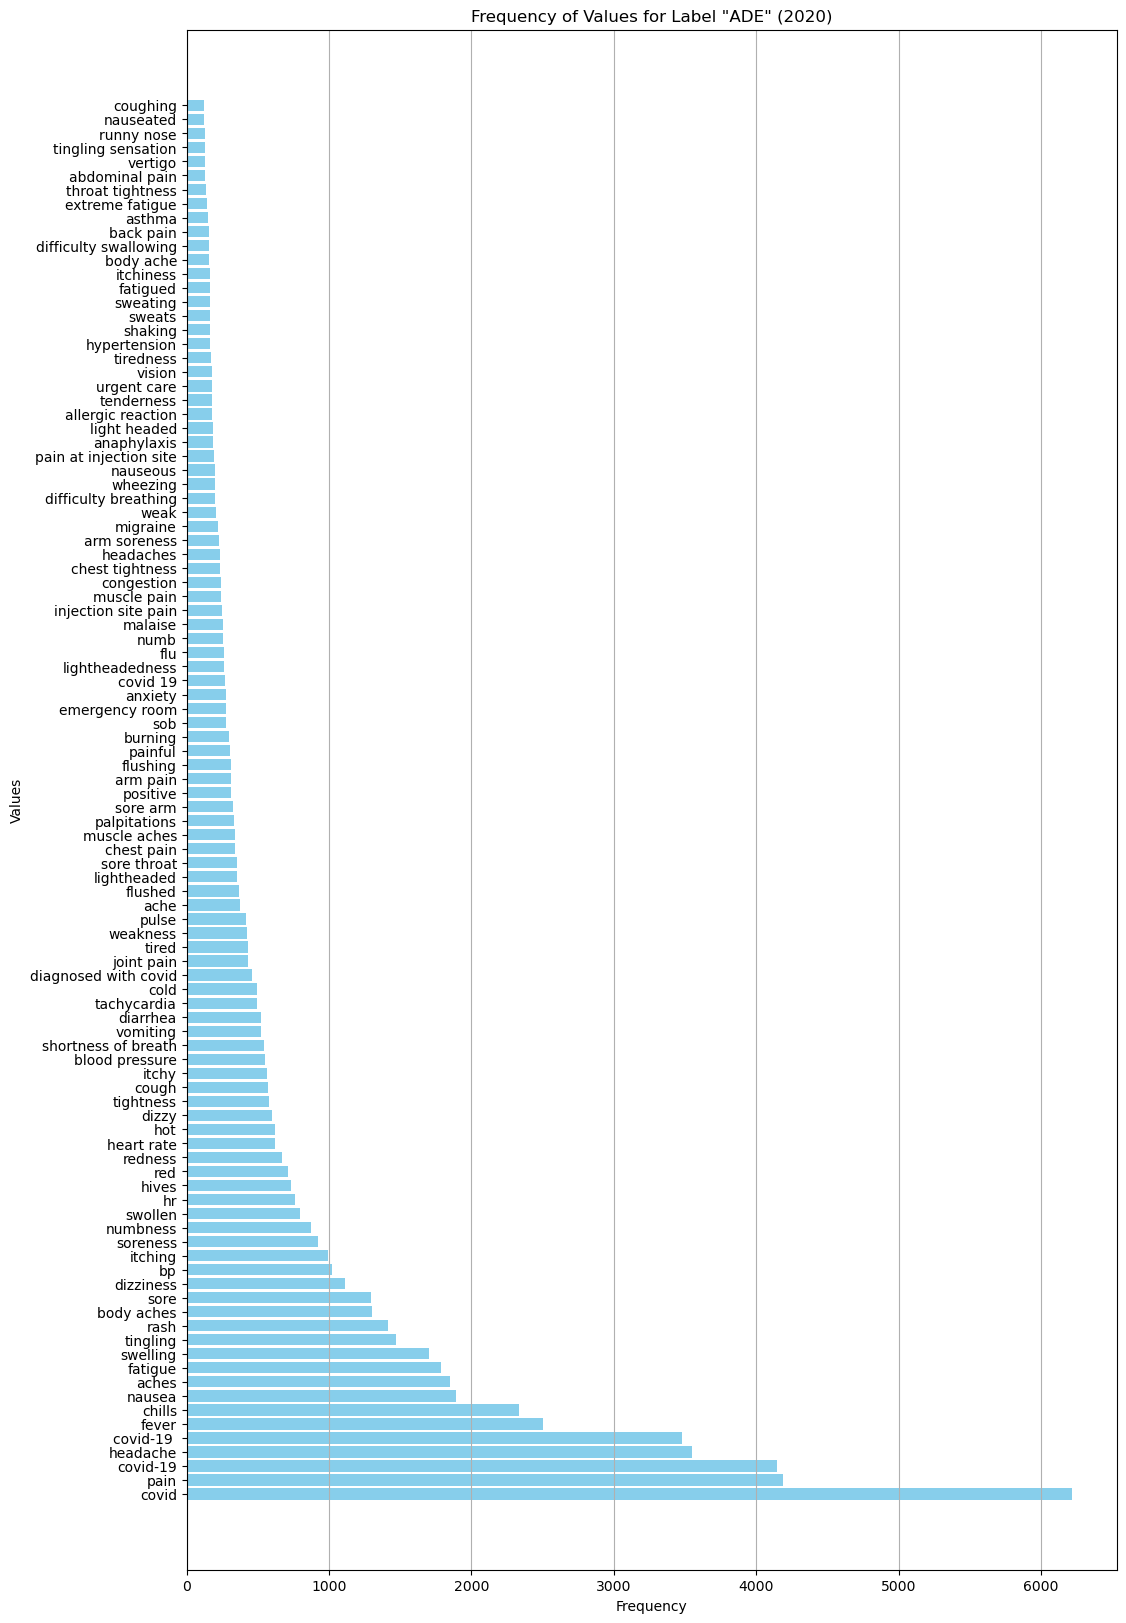

In [145]:
# Step 1: Filter the DataFrame for the label "ADE"
entity_ADE_2020 = df_pred_2020[df_pred_2020['label'] == 'ADE']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_ADE_2020 = entity_ADE_2020['entity_value'].str.lower().value_counts()
top_10_value_counts_ADE_2020 = value_counts_ADE_2020.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_ADE_2020.index, top_10_value_counts_ADE_2020.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "ADE" (2020)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

### Applying dict LF for 2023

In [146]:
vaers_all_2023 = vaers_all[vaers_all['YEAR'].isin([2023])]

In [149]:
num_cpus = multiprocessing.cpu_count()
n = len(vaers_all_2023)

# Aim for ~5× number of cores in parallel tasks
num_batches = num_cpus * 5
batch_size = max(100, n // num_batches)  

print(f"Auto batch size: {batch_size}")

Auto batch size: 1973


In [49]:
# Detect number of CPU cores
num_cpus = multiprocessing.cpu_count()
print(f"Detected {num_cpus} CPU cores. Using Ray with {num_cpus} workers.")

# Start Ray with detected CPUs
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

@ray.remote
def process_batch(batch_df):
    results = []
    for _, row in batch_df.iterrows():
        vaers_id, text = row["VAERS_ID"], row["SYMPTOM_TEXT"]

        if pd.isna(text):
            continue

        text = str(text)

        # Apply DRUG LF
        for match in lf_dict(text, dict_DRUG, "DRUG"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

        # Apply ADE LF
        for match in lf_dict(text, dict_ADE, "ADE"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

    return results


# Prepare batches
df = vaers_all_2023[['VAERS_ID', 'SYMPTOM_TEXT']].drop_duplicates()
batch_size = 2000
batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

# Submit jobs
futures = [process_batch.remote(batch) for batch in batches]

# Collect results with tqdm progress bar
results = []
with tqdm(total=len(futures), desc="Processing batches") as pbar:
    while futures:
        done, futures = ray.wait(futures, num_returns=1, timeout=None)
        for obj in done:
            results.append(ray.get(obj))
            pbar.update(1)

# Flatten results
all_predictions_2023 = [m for sublist in results for m in sublist]
df_pred_2023 = pd.DataFrame(all_predictions_2023)
df_pred_2023 = df_pred_2023[['VAERS_ID', 'start', 'end', 'label', 'entity_value']]

2025-09-09 21:04:23,262	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.


Detected 8 CPU cores. Using Ray with 8 workers.


Processing batches: 100%|██████████| 15/15 [39:18<00:00, 157.20s/it] 


In [ ]:
df_pred_2023[
    (df_pred_2023['label'] == 'ADE') &
    (df_pred_2023['entity_value'].str.lower() == 'mrna-1273')
]


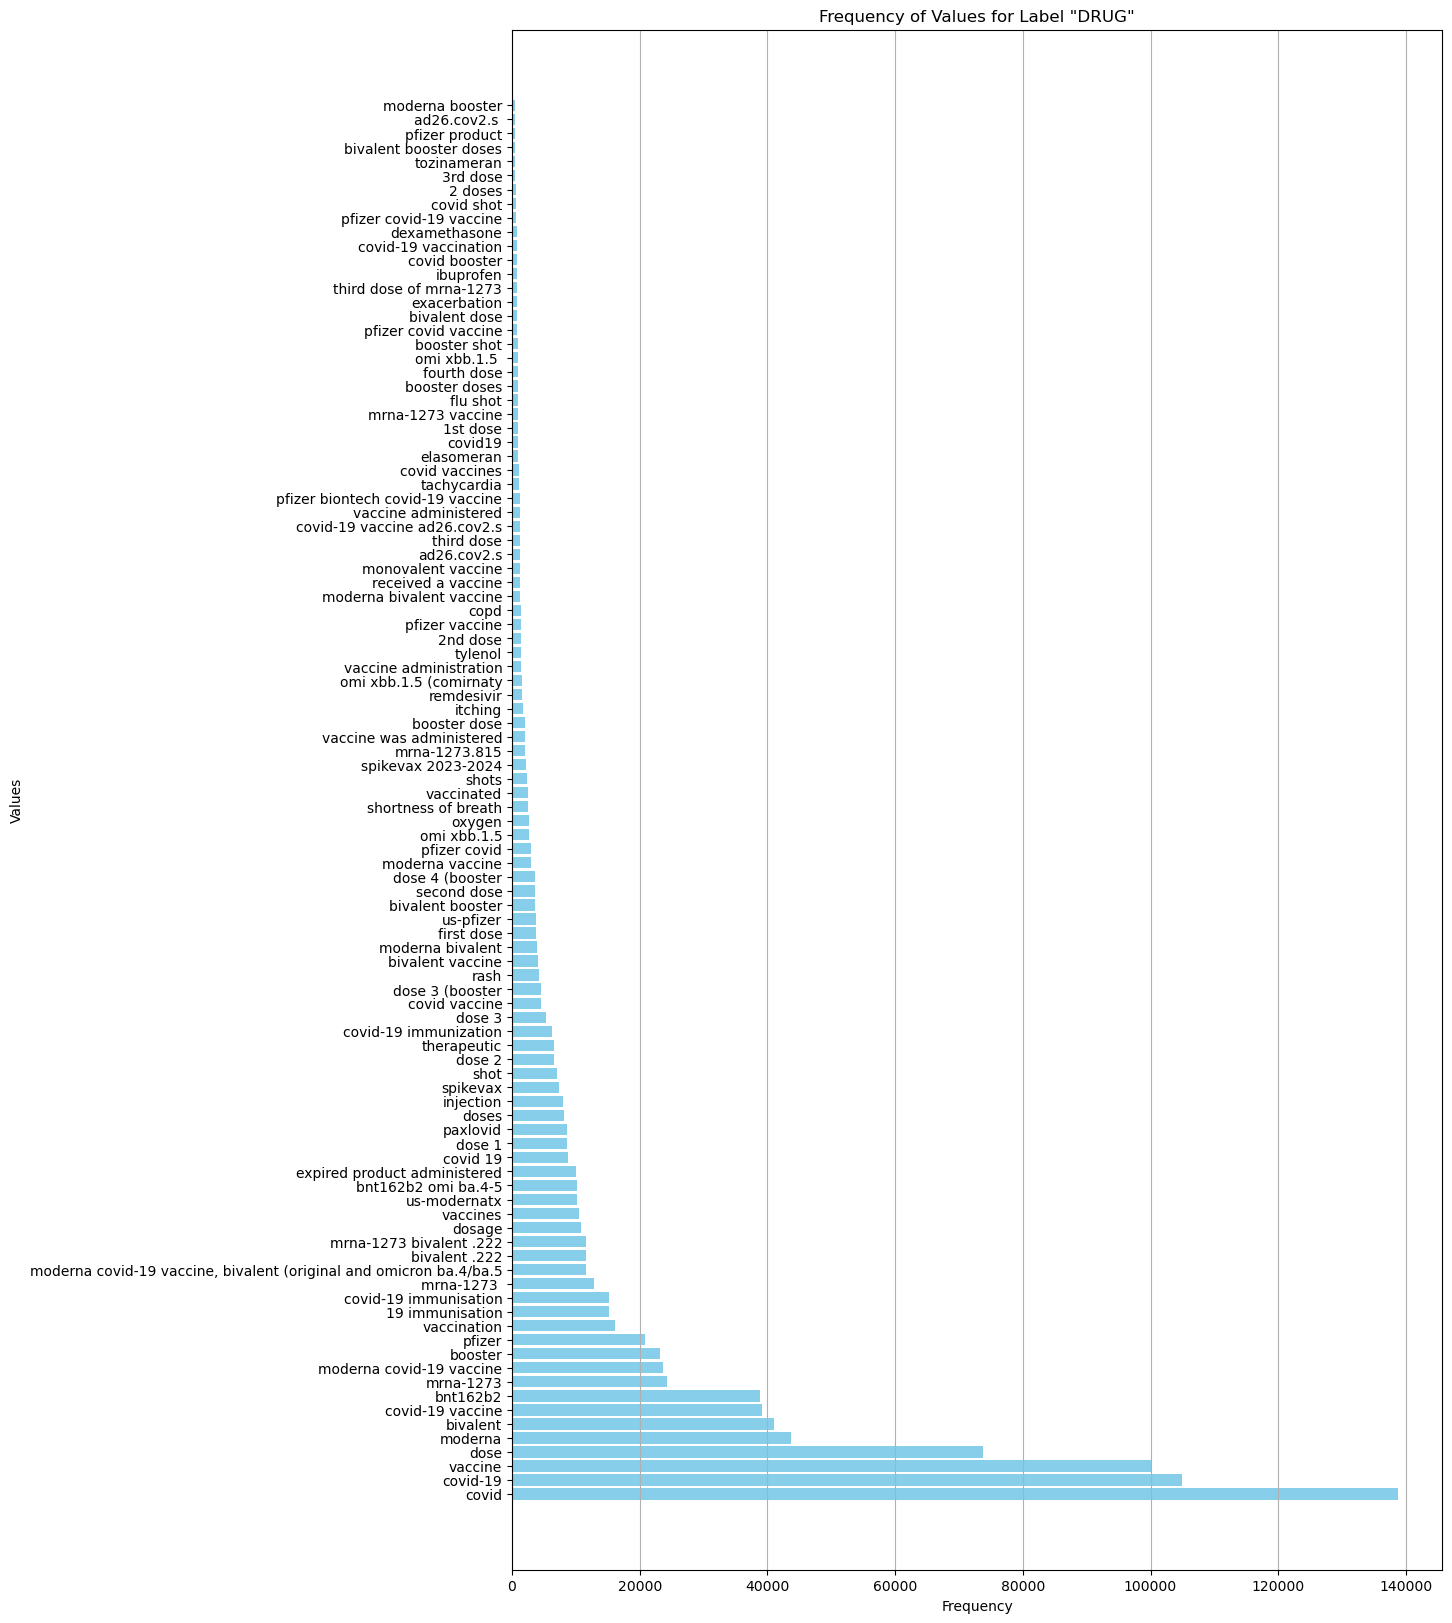

In [ ]:
# Step 1: Filter the DataFrame for the label "DRUG"
entity_DRUG_2023 = df_pred_2023[df_pred_2023['label'] == 'DRUG']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_DRUG_2023 = entity_DRUG_2023['entity_value'].str.lower().value_counts()
top_10_value_counts_DRUG_2023 = value_counts_DRUG_2023.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_DRUG_2023.index, top_10_value_counts_DRUG_2023.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "DRUG" (2023)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

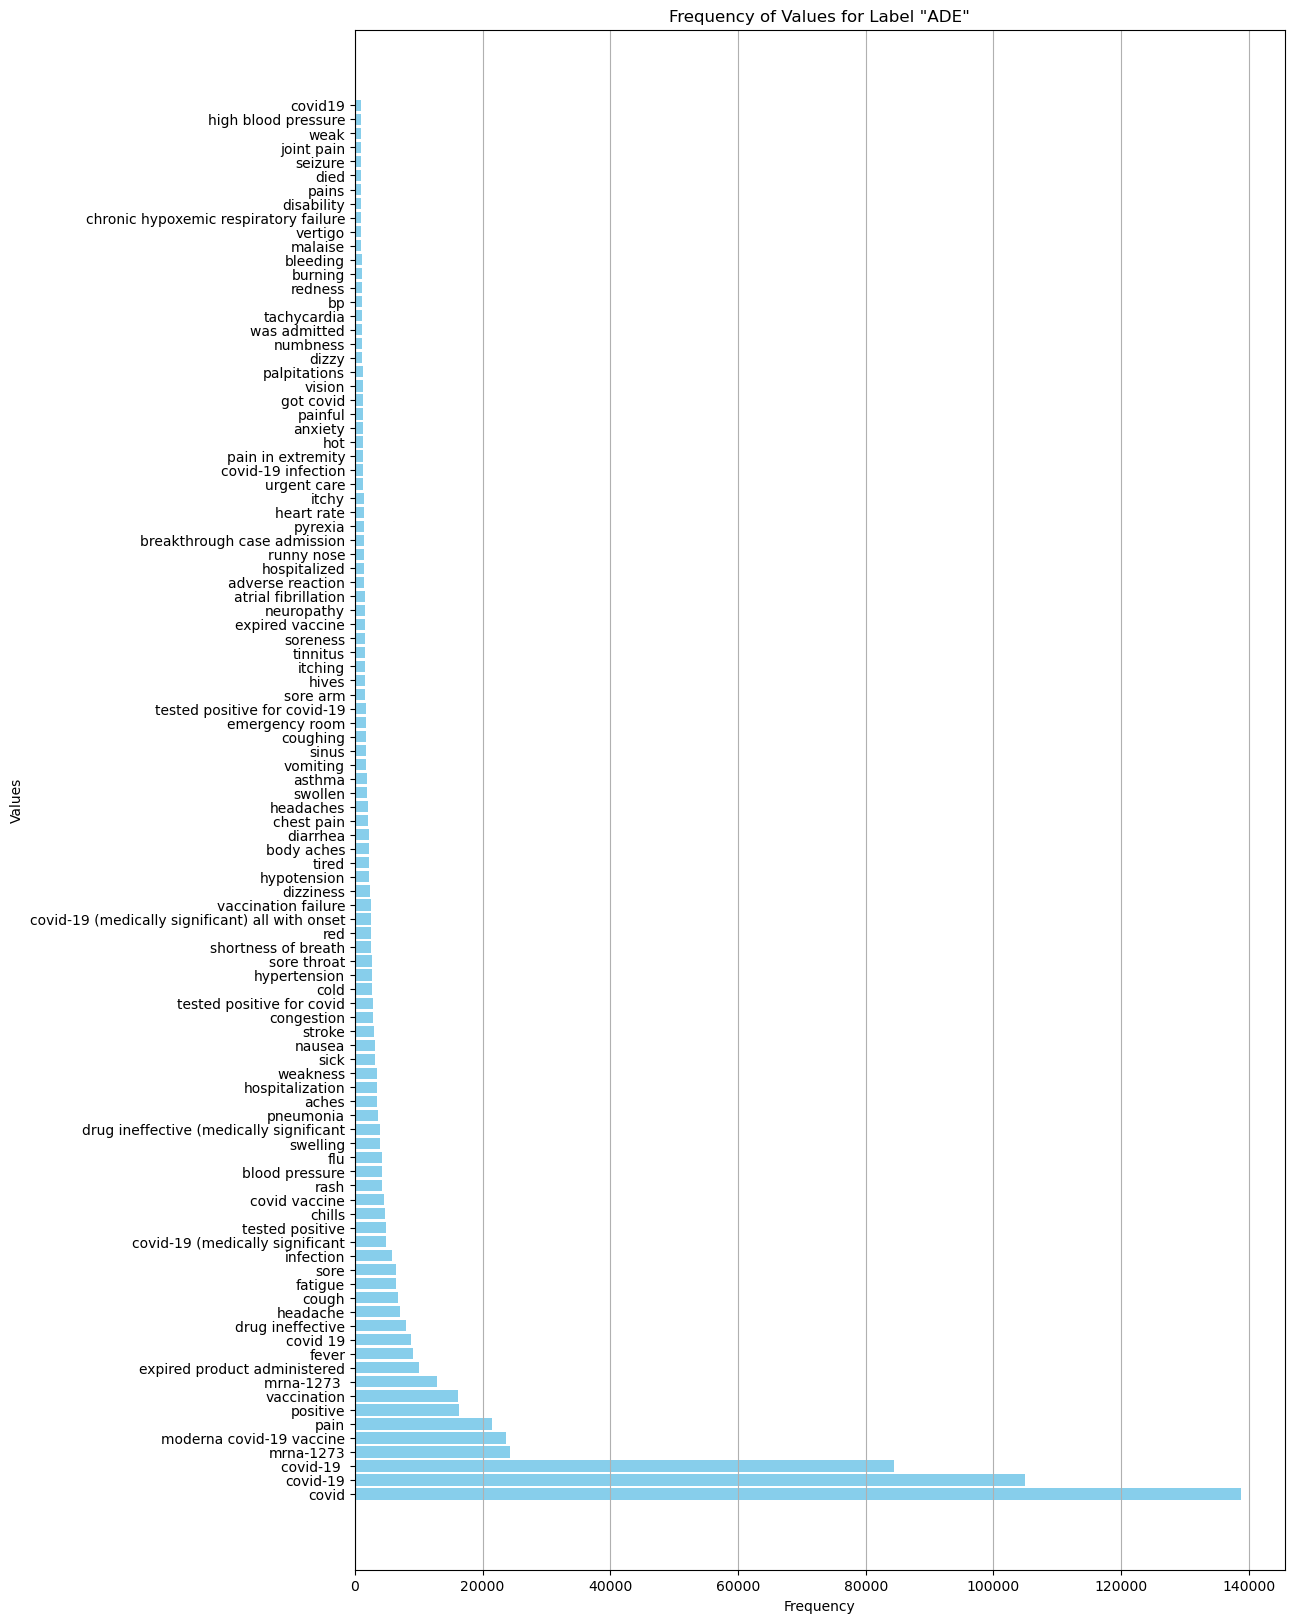

In [51]:
# Step 1: Filter the DataFrame for the label "ADE"
entity_ADE = df_pred_2023[df_pred_2023['label'] == 'ADE']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_ADE = entity_ADE['entity_value'].str.lower().value_counts()
top_10_value_counts_ADE = value_counts_ADE.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_ADE.index, top_10_value_counts_ADE.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "ADE"')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

### Applying dict LF for 2024

In [150]:
vaers_all_2024 = vaers_all[vaers_all['YEAR'].isin([2024])]

In [151]:
num_cpus = multiprocessing.cpu_count()
n = len(vaers_all_2024)

# Aim for ~5× number of cores in parallel tasks
num_batches = num_cpus * 5
batch_size = max(100, n // num_batches)  

print(f"Auto batch size: {batch_size}")

Auto batch size: 546


In [157]:
# Detect number of CPU cores
num_cpus = multiprocessing.cpu_count()
print(f"Detected {num_cpus} CPU cores. Using Ray with {num_cpus} workers.")

# Start Ray with detected CPUs
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

@ray.remote
def process_batch(batch_df):
    results = []
    for _, row in batch_df.iterrows():
        vaers_id, text = row["VAERS_ID"], row["SYMPTOM_TEXT"]

        if pd.isna(text):
            continue

        text = str(text)

        # Apply DRUG LF
        for match in lf_dict(text, dict_DRUG, "DRUG"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

        # Apply ADE LF
        for match in lf_dict(text, dict_ADE, "ADE"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

    return results


# Prepare batches
df = vaers_all_2024[['VAERS_ID', 'SYMPTOM_TEXT']].drop_duplicates()
batch_size = 546
batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

# Submit jobs
futures = [process_batch.remote(batch) for batch in batches]

# Collect results with tqdm progress bar
results = []
with tqdm(total=len(futures), desc="Processing batches") as pbar:
    while futures:
        done, futures = ray.wait(futures, num_returns=1, timeout=None)
        for obj in done:
            results.append(ray.get(obj))
            pbar.update(1)

# Flatten results
all_predictions_2024 = [m for sublist in results for m in sublist]
df_pred_2024 = pd.DataFrame(all_predictions_2024)
df_pred_2024 = df_pred_2024[['VAERS_ID', 'start', 'end', 'label', 'entity_value']]


2025-09-10 02:33:39,978	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.


Detected 8 CPU cores. Using Ray with 8 workers.


Processing batches: 100%|██████████| 37/37 [07:20<00:00, 11.90s/it]


In [ ]:
df_pred_2024[
    (df_pred_2024['label'] == 'ADE') &
    (df_pred_2024['entity_value'].str.lower() == 'mrna-1273')
]

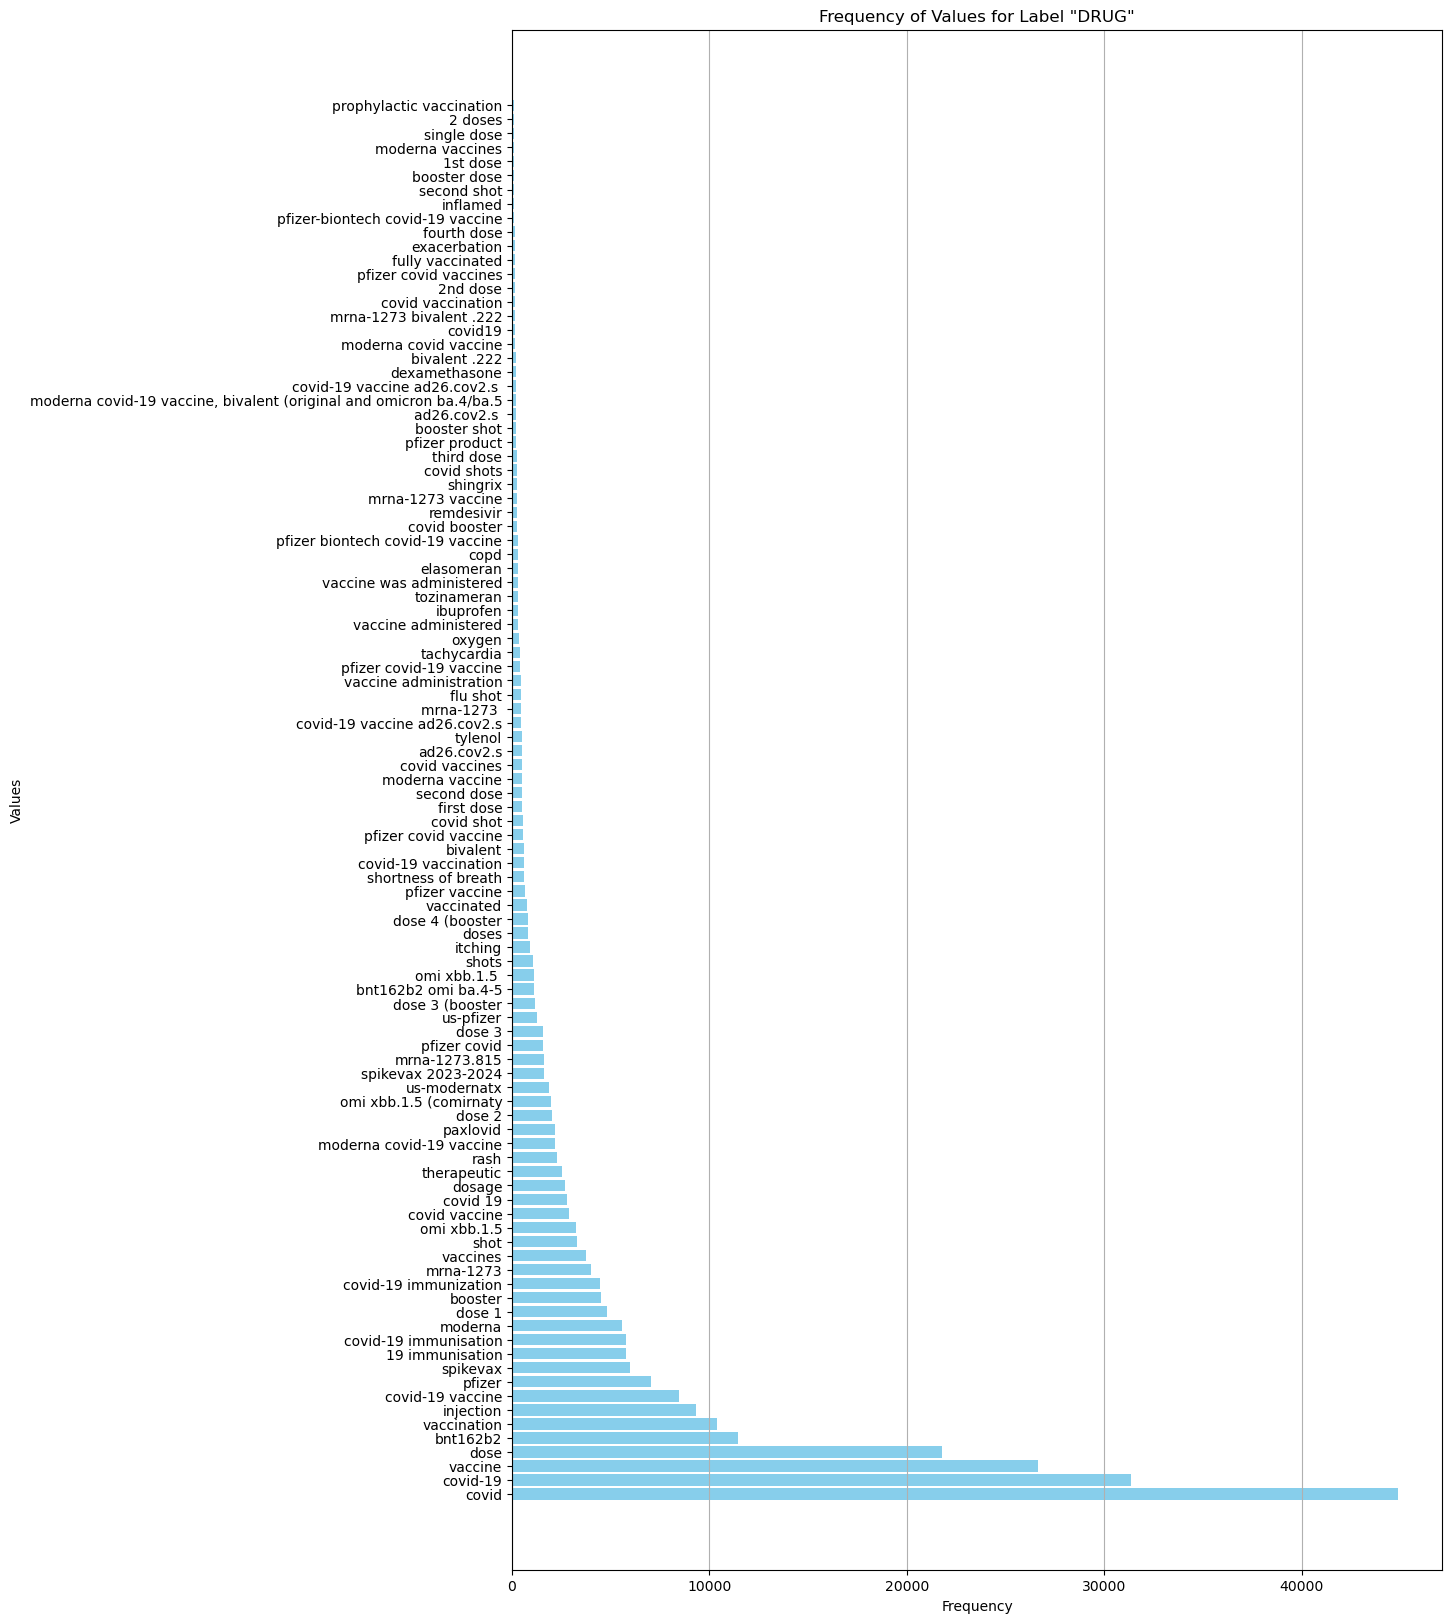

In [ ]:
# Step 1: Filter the DataFrame for the label "DRUG"
entity_DRUG_2024 = df_pred_2024[df_pred_2024['label'] == 'DRUG']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_DRUG_2024 = entity_DRUG_2024['entity_value'].str.lower().value_counts()
top_10_value_counts_DRUG_2024 = value_counts_DRUG_2024.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_DRUG_2024.index, top_10_value_counts_DRUG_2024.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "DRUG" (2024)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

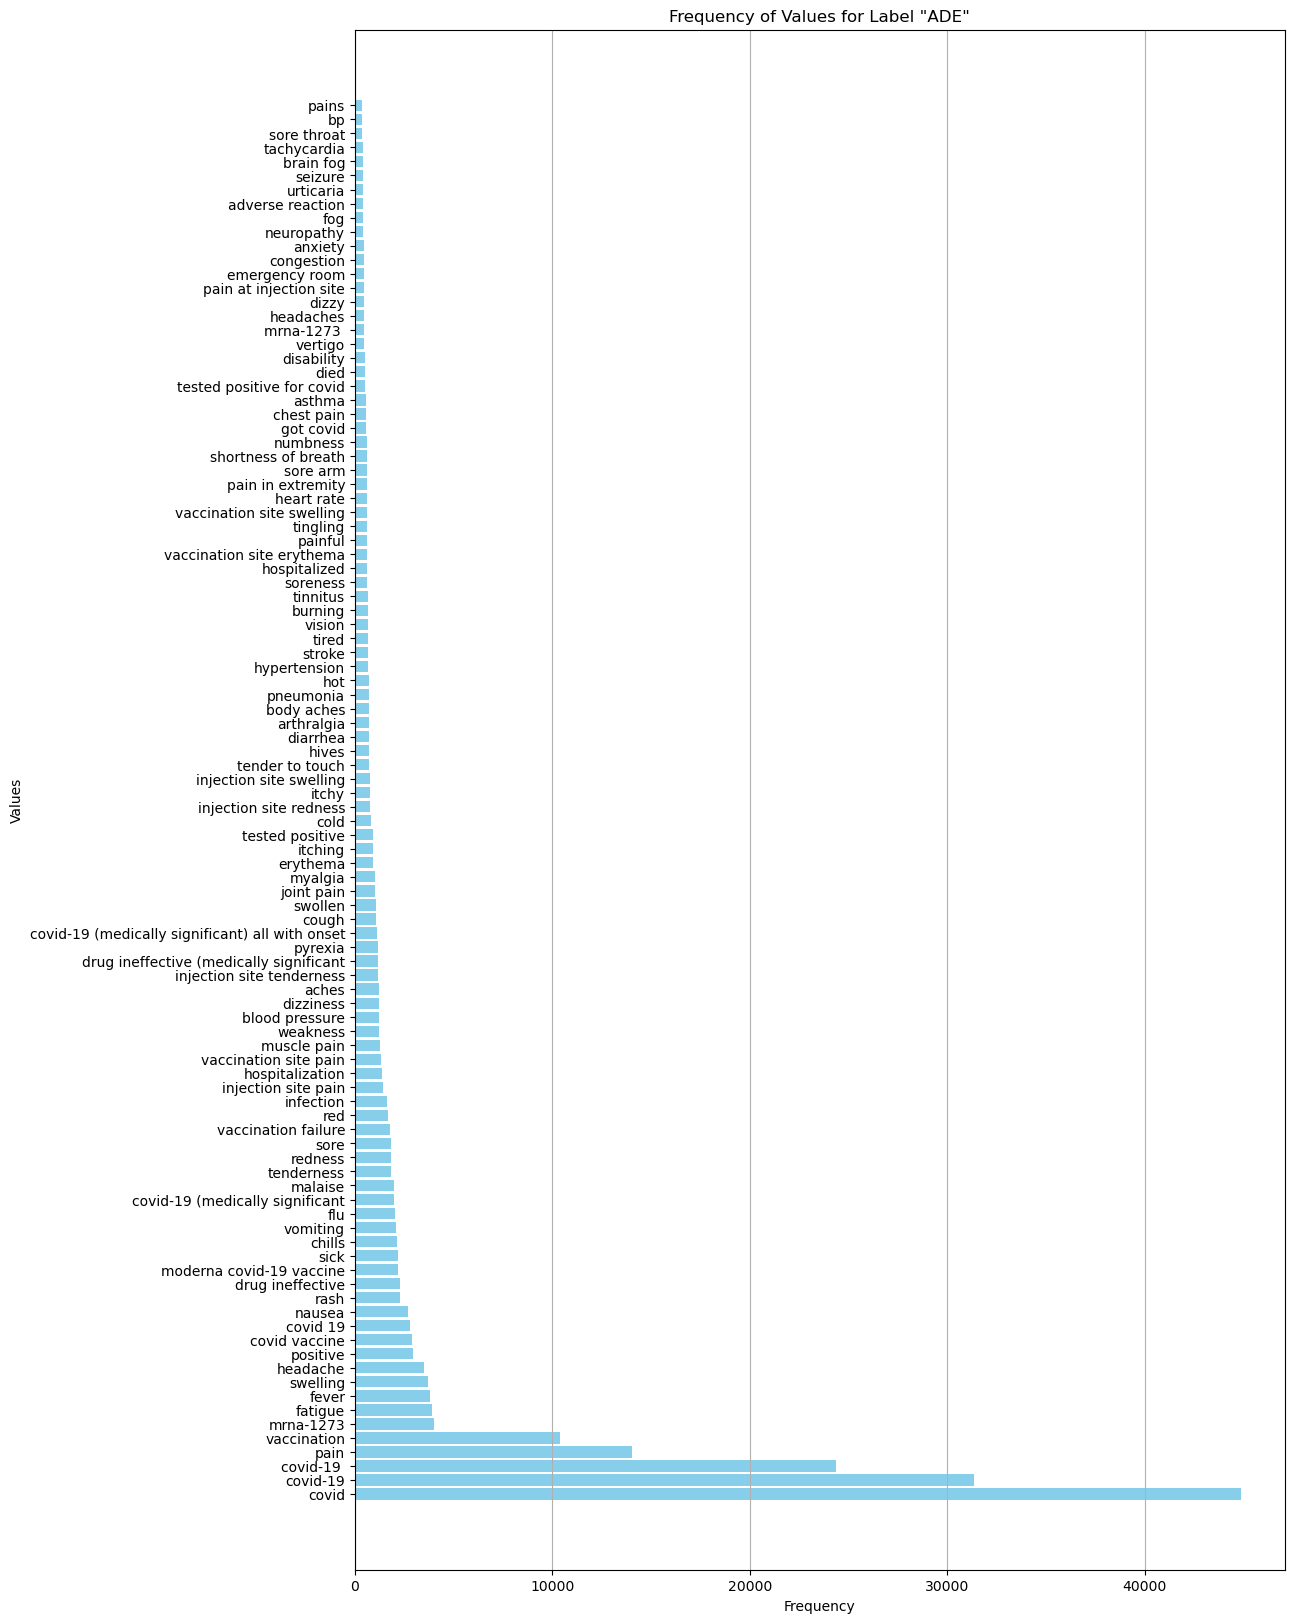

In [ ]:
# Step 1: Filter the DataFrame for the label "DRUG"
entity_DRUG_2024 = df_pred_2024[df_pred_2024['label'] == 'DRUG']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_DRUG_2024 = entity_DRUG_2024['entity_value'].str.lower().value_counts()
top_10_value_counts_DRUG_2024 = value_counts_DRUG_2024.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_DRUG_2024.index, top_10_value_counts_DRUG_2024.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "DRUG" (2024)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

### Applying dict LF for 2025

In [44]:
vaers_all_2025 = vaers_all[vaers_all['YEAR'].isin([2025])]

In [152]:
num_cpus = multiprocessing.cpu_count()
n = len(vaers_all_2025)

# Aim for ~5× number of cores in parallel tasks
num_batches = num_cpus * 5
batch_size = max(100, n // num_batches)  

print(f"Auto batch size: {batch_size}")

Auto batch size: 120


In [153]:
# Detect number of CPU cores
num_cpus = multiprocessing.cpu_count()
print(f"Detected {num_cpus} CPU cores. Using Ray with {num_cpus} workers.")

# Start Ray with detected CPUs
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

@ray.remote
def process_batch(batch_df):
    results = []
    for _, row in batch_df.iterrows():
        vaers_id, text = row["VAERS_ID"], row["SYMPTOM_TEXT"]

        if pd.isna(text):
            continue

        text = str(text)

        # Apply DRUG LF
        for match in lf_dict(text, dict_DRUG, "DRUG"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

        # Apply ADE LF
        for match in lf_dict(text, dict_ADE, "ADE"):
            match['VAERS_ID'] = vaers_id
            results.append(match)

    return results


# Prepare batches
df = vaers_all_2025[['VAERS_ID', 'SYMPTOM_TEXT']].drop_duplicates()
batch_size = 120
batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

# Submit jobs
futures = [process_batch.remote(batch) for batch in batches]

# Collect results with tqdm progress bar
results = []
with tqdm(total=len(futures), desc="Processing batches") as pbar:
    while futures:
        done, futures = ray.wait(futures, num_returns=1, timeout=None)
        for obj in done:
            results.append(ray.get(obj))
            pbar.update(1)

# Flatten results
all_predictions_2025 = [m for sublist in results for m in sublist]
df_pred_2025 = pd.DataFrame(all_predictions_2025)
df_pred_2025 = df_pred_2025[['VAERS_ID', 'start', 'end', 'label', 'entity_value']]


2025-09-10 02:28:46,006	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.


Detected 8 CPU cores. Using Ray with 8 workers.


Processing batches: 100%|██████████| 37/37 [01:42<00:00,  2.76s/it]


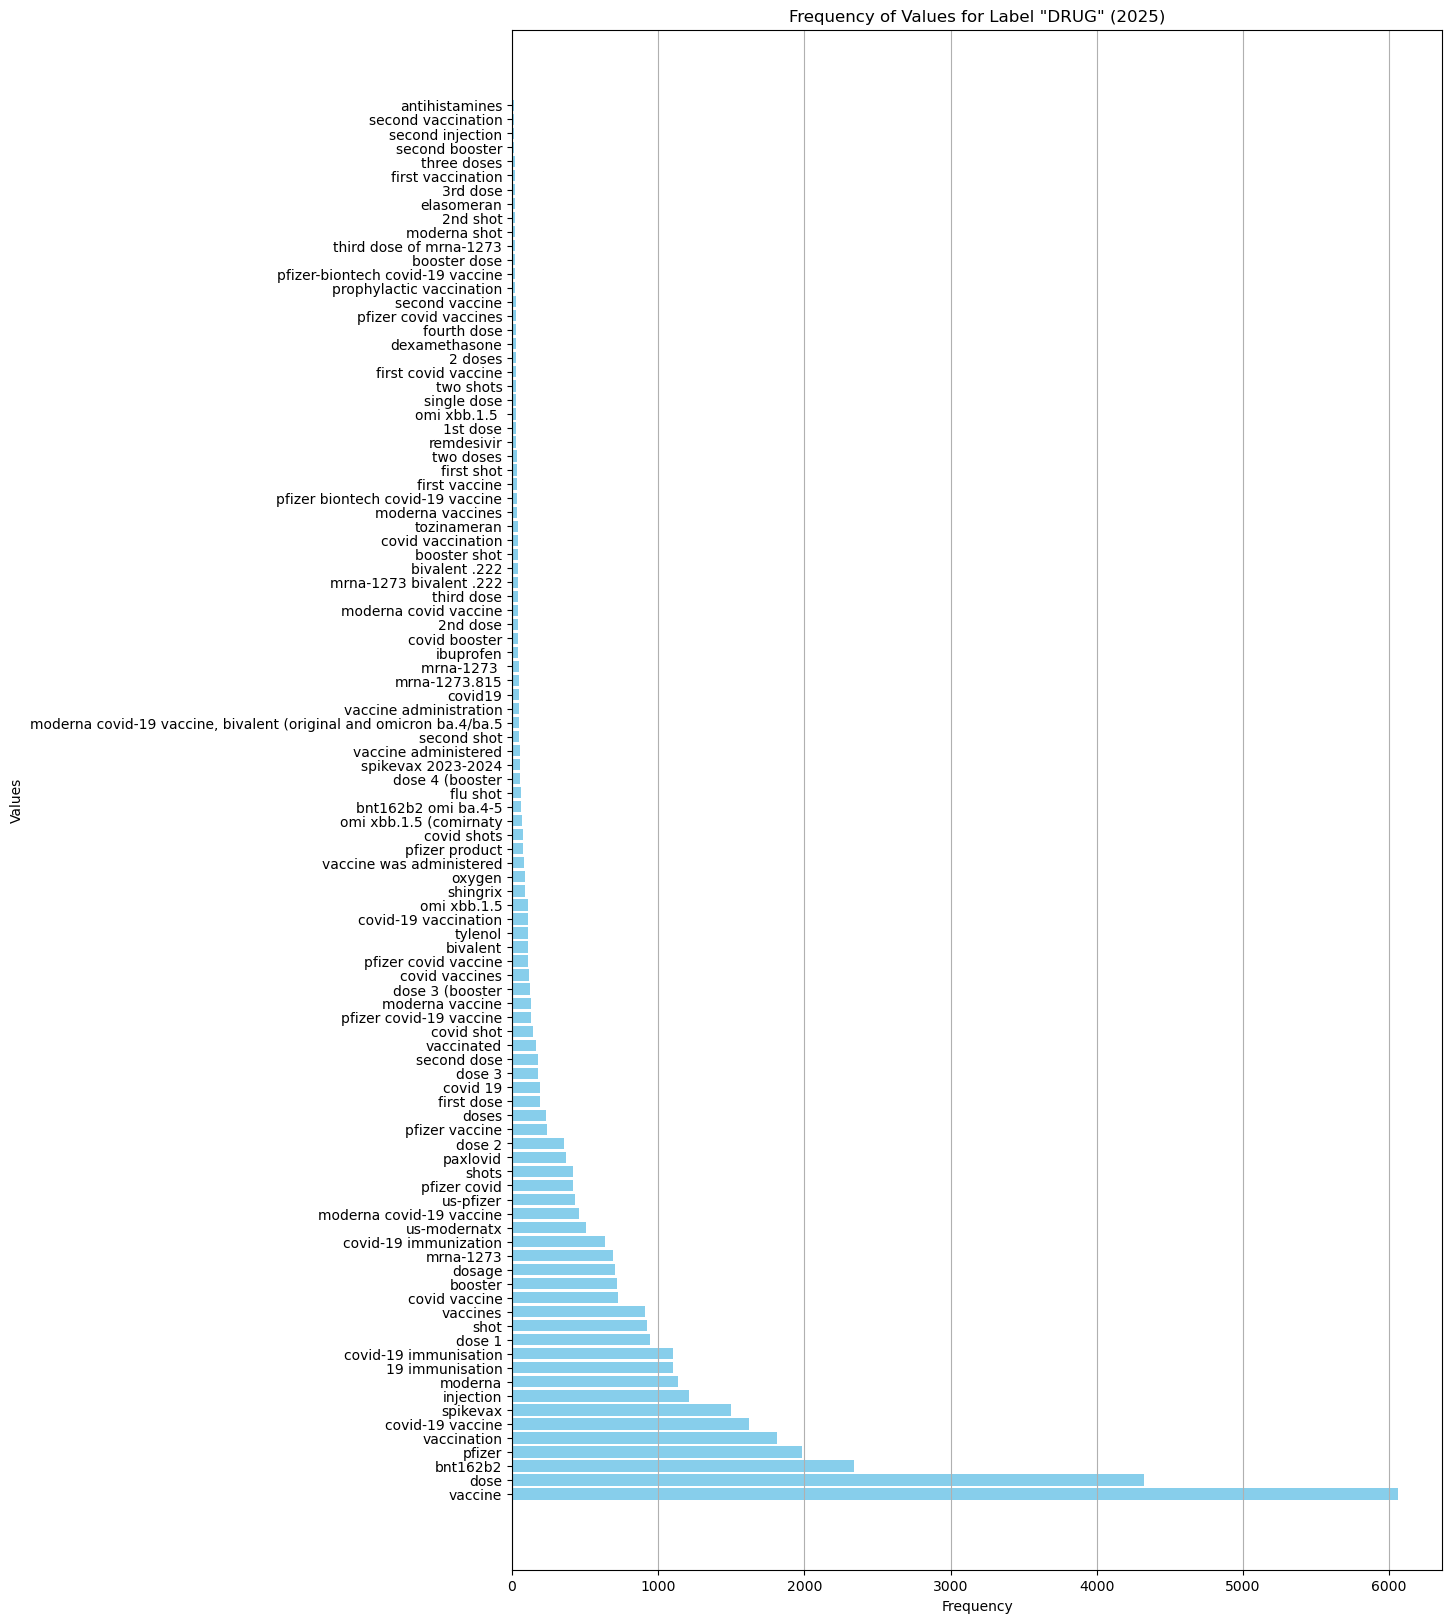

In [154]:
# Step 1: Filter the DataFrame for the label "DRUG"
entity_DRUG_2025 = df_pred_2025[df_pred_2025['label'] == 'DRUG']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_DRUG_2025 = entity_DRUG_2025['entity_value'].str.lower().value_counts()
top_10_value_counts_DRUG_2025 = value_counts_DRUG_2025.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_DRUG_2025.index, top_10_value_counts_DRUG_2025.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "DRUG" (2025)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()

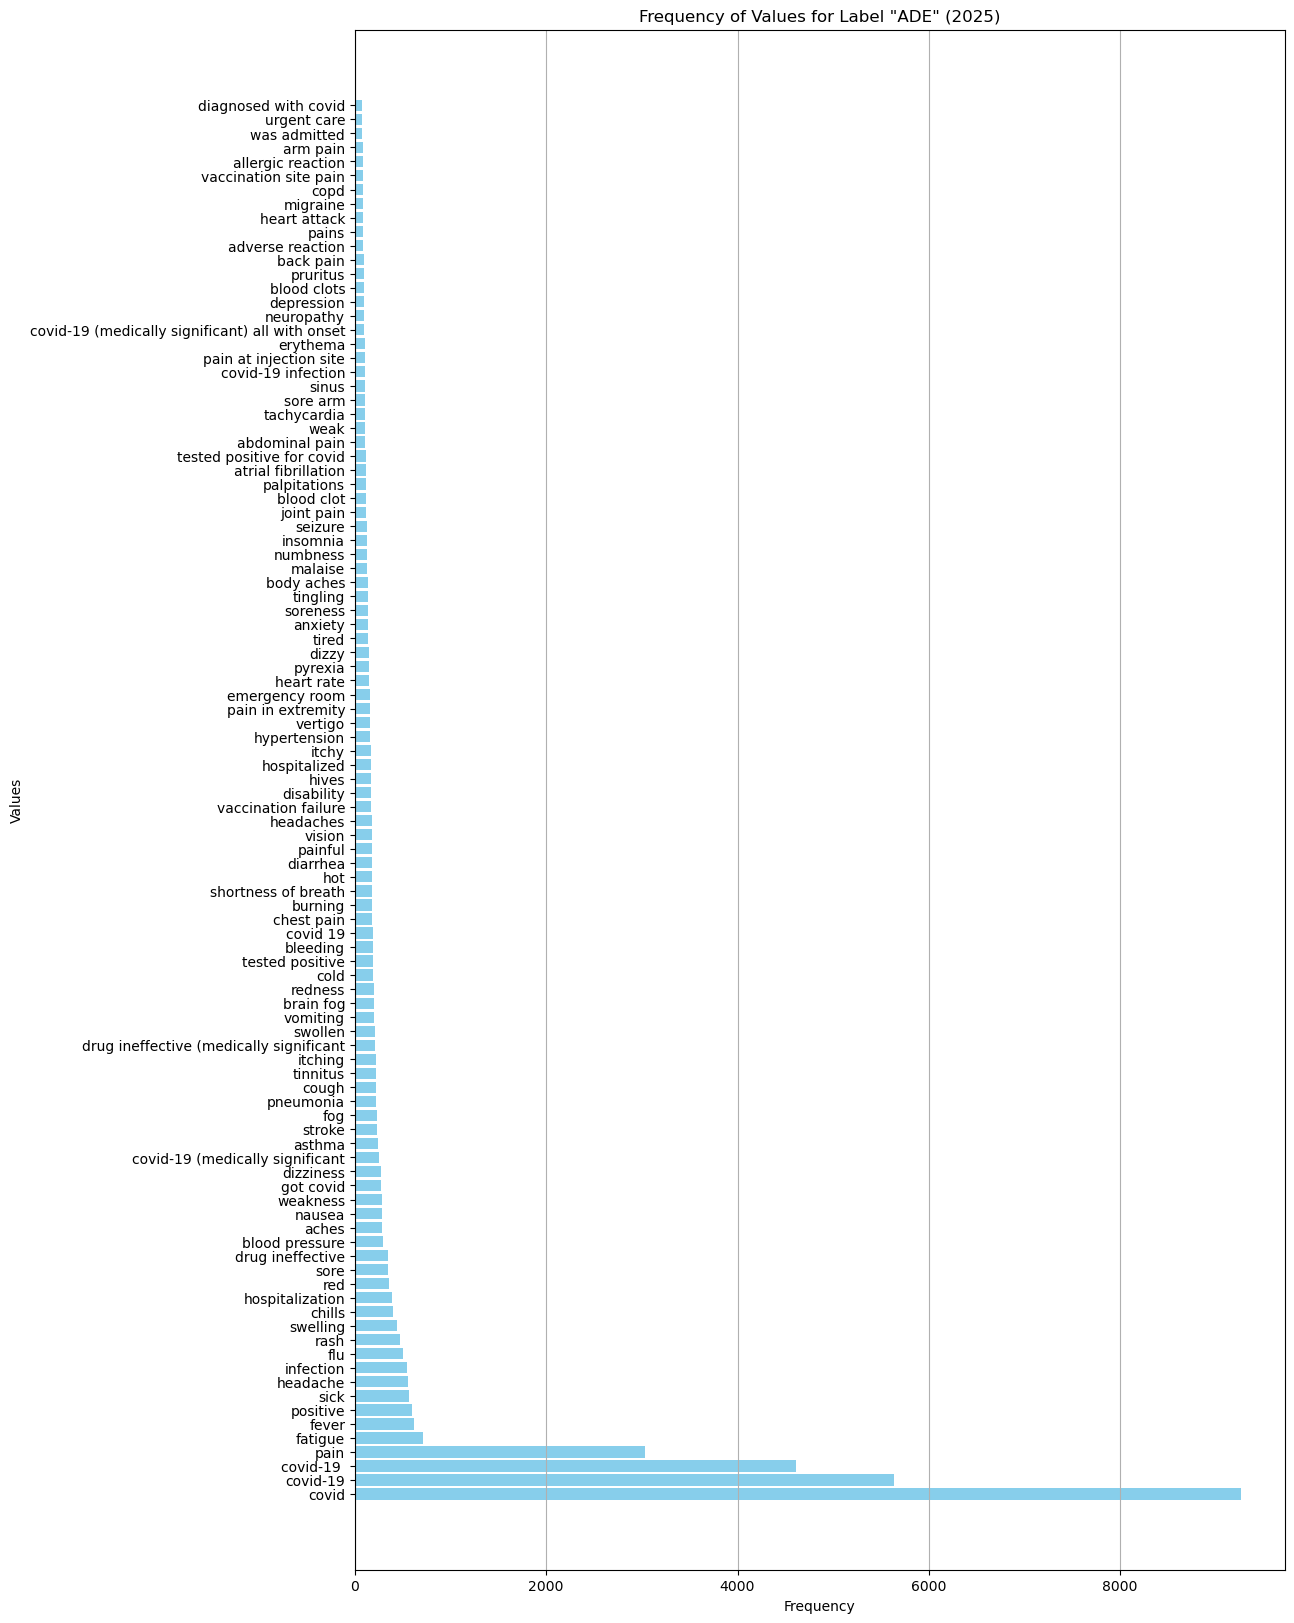

In [155]:
# Step 1: Filter the DataFrame for the label "ADE"
entity_ADE_2025 = df_pred_2025[df_pred_2025['label'] == 'ADE']

# Step 2: Count the frequency of each value after converting to lowercase
value_counts_ADE_2025 = entity_ADE_2025['entity_value'].str.lower().value_counts()
top_10_value_counts_ADE_2025 = value_counts_ADE_2025.head(100)

# Step 3: Plotting the frequencies (horizontal bar plot)
plt.figure(figsize=(12, 20))
plt.barh(top_10_value_counts_ADE_2025.index, top_10_value_counts_ADE_2025.values, color='skyblue')  # Use barh for horizontal bars
plt.title('Frequency of Values for Label "ADE" (2025)')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.grid(axis='x')
plt.show()